In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

import numpy as np
import h5py

hf = h5py.File("/Users/abletimin/cernbox/b-tagg/btagging-ml_tutorial_files/MC16d_hybrid-training_sample-NN.h5", 'r')
print(hf.keys())
X_train, Y_train = hf['X_train'][:], hf['Y_train'][:]
hf.close()   

<KeysViewHDF5 ['X_train', 'X_trk_train', 'Y_train']>


In [3]:
len(X_train[:,0])

2072727

## DL1 model 

hiden layers: 72, 57, 60, 48, 36, 24, 12, 6  
structures: Dense -> BatchNorm -> Relu -> Dropout  
No drop out on inputs   
  
output layer: 3  

In [30]:
DL1_layers = [ 72, 57, 60, 48, 36,24, 12, 6]
DL1_dropouts = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
dropout_enable = True

def get_DL1(N_features, h_layers, lr=0.01, drops=None):
    In = tf.keras.layers.Input(shape=(N_features,), name="inputs")
    x = In
            
    for i, h in enumerate(h_layers):
        
        x = keras.layers.Dense(h, activation="linear",
                  kernel_initializer='glorot_uniform', name="dense%s"%(i))(x)
        x = keras.layers.BatchNormalization(name="BN%s"%(i))(x)
        x = keras.layers.Activation("relu", name="activ%s"%(i))(x)
        
        if drops:
            x = keras.layers.Dropout(drops[i], name="drop%s"%(i))(x, training=True)
            
    predictions = keras.layers.Dense(3, activation='softmax',
                        kernel_initializer='glorot_uniform', name="outputs")(x)

    model = keras.models.Model(inputs=In, outputs=predictions)

    model_optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=model_optimizer,
        metrics=['accuracy']
    )
    return model
DL1_model =  get_DL1 (X_train.shape[-1], h_layers=DL1_layers, drops=DL1_dropouts)
DL1_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 44)]              0         
_________________________________________________________________
dense0 (Dense)               (None, 72)                3240      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 72)                288       
_________________________________________________________________
activ0 (Activation)          (None, 72)                0         
_________________________________________________________________
drop0 (Dropout)              (None, 72)                0         
_________________________________________________________________
dense1 (Dense)               (None, 57)                4161      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 57)                228 

In [31]:
def GetRejection(y_pred, y_true):
    """Calculates the c and light rejection for 77% WP and 0.018 c-fraction."""
    b_index, c_index, u_index = 2, 1, 0
    cfrac = 0.018
    target_beff = 0.77
    y_true = np.argmax(y_true, axis=1)
    b_jets = y_pred[y_true == b_index]
    c_jets = y_pred[y_true == c_index]
    u_jets = y_pred[y_true == u_index]
    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
                                           (1 - cfrac) * b_jets[:, u_index]))
    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

    c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
                                                    + (1 - cfrac) *
                                                    c_jets[:, u_index])) >
                       cutvalue]) / float(len(c_jets))
    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
                                                    u_jets[:, c_index] +
                                                    (1 - cfrac) *
                                                    u_jets[:, u_index])) >
                       cutvalue]) / float(len(u_jets))

    if c_eff == 0 or u_eff == 0:
        return -1, -1
    return 1. / c_eff, 1. / u_eff


class MyCallback(Callback):
    """Custom callback function calculating per epoch light and c-rejection and saves the model of each epoch."""
    def __init__(self, X_valid=0, Y_valid=0,
                 model_name='test', store_all=False):
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.result = []
        self.model_name = model_name
        os.system("mkdir -p %s" % self.model_name)
        self.dict_list = []
        self.store_all = store_all

    def on_epoch_end(self, epoch, logs=None):
        if self.store_all:
            self.model.save('%s/model_epoch%i.h5' % (self.model_name, epoch))
        y_pred = self.model.predict(self.X_valid, batch_size=5000)
        c_rej, u_rej = GetRejection(y_pred, self.Y_valid)
        dict_epoch = {
            "epoch": epoch,
            "loss": float(logs['loss']),
            "acc": float(logs['accuracy']),
            "val_loss": float(logs['val_loss']),
            "val_acc": float(logs['val_accuracy']),
            "c_rej": c_rej,
            "u_rej": u_rej
        }

        self.dict_list.append(dict_epoch)
        with open('%s/DictFile.json' % self.model_name, 'w') as outfile:
            json.dump(self.dict_list, outfile, indent=4)
            


In [42]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.00001)


callbacks = [reduce_lr]

history=DL1_model.fit(X_train, Y_train,
          epochs=150, # typically ~130 are necessary to converge
          batch_size=5000,
          callbacks=callbacks,
          )

Epoch 1/150
1/1 [==============================] - 0s 8ms/step - loss: 0.7684 - accuracy: 0.6100
Epoch 2/150
1/1 [==============================] - 0s 7ms/step - loss: 0.7565 - accuracy: 0.6300
Epoch 3/150
1/1 [==============================] - 0s 6ms/step - loss: 0.7730 - accuracy: 0.6000
Epoch 4/150
1/1 [==============================] - 0s 28ms/step - loss: 0.7838 - accuracy: 0.6300
Epoch 5/150
1/1 [==============================] - 0s 9ms/step - loss: 0.7717 - accuracy: 0.5500
Epoch 6/150
1/1 [==============================] - 0s 6ms/step - loss: 0.7402 - accuracy: 0.5900
Epoch 7/150
1/1 [==============================] - 0s 13ms/step - loss: 0.7479 - accuracy: 0.6400
Epoch 8/150
1/1 [==============================] - 0s 16ms/step - loss: 0.7324 - accuracy: 0.6200
Epoch 9/150
1/1 [==============================] - 0s 13ms/step - loss: 0.7358 - accuracy: 0.6000
Epoch 10/150
1/1 [==============================] - 0s 7ms/step - loss: 0.7544 - accuracy: 0.6000
Epoch 11/150
1/1 [=======

Epoch 84/150
1/1 [==============================] - 0s 16ms/step - loss: 0.7654 - accuracy: 0.5700
Epoch 85/150
1/1 [==============================] - 0s 11ms/step - loss: 0.7340 - accuracy: 0.6500
Epoch 86/150
1/1 [==============================] - 0s 22ms/step - loss: 0.7140 - accuracy: 0.6300
Epoch 87/150
1/1 [==============================] - 0s 15ms/step - loss: 0.7148 - accuracy: 0.6300
Epoch 88/150
1/1 [==============================] - 0s 11ms/step - loss: 0.7370 - accuracy: 0.6100
Epoch 89/150
1/1 [==============================] - 0s 14ms/step - loss: 0.7714 - accuracy: 0.5700
Epoch 90/150
1/1 [==============================] - 0s 9ms/step - loss: 0.7662 - accuracy: 0.6300
Epoch 91/150
1/1 [==============================] - 0s 10ms/step - loss: 0.7605 - accuracy: 0.5900
Epoch 92/150
1/1 [==============================] - 0s 13ms/step - loss: 0.7335 - accuracy: 0.6500
Epoch 93/150
1/1 [==============================] - 0s 12ms/step - loss: 0.7431 - accuracy: 0.6500
Epoch 94/15

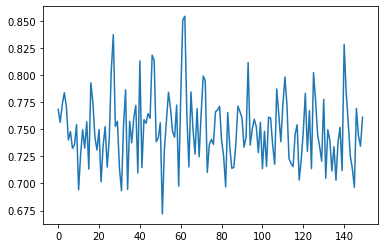

In [43]:
import matplotlib
import matplotlib.pyplot as plt 
plt.plot(range(len(history.history['loss'])), history.history['loss'])